<a href="https://colab.research.google.com/github/AngelPerez98/Robot_Trading_AluraDS/blob/main/Challenge_Robot_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Challenge - Robot Trading

##1. Configuracion del ambiente

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import time

global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

In [2]:
!python -V
print('------')
!pip show Pandas | grep 'Name\|Version'
print('------')
!pip show Numpy | grep 'Name\|Version'
print('------')
!pip show Matplotlib | grep 'Name\|Version'
print('------')

Python 3.10.12
------
Name: pandas
Version: 1.5.3
------
Name: numpy
Version: 1.23.5
------
Name: matplotlib
Version: 3.7.1
------


##2. Obtención de datos

In [3]:
#Aquí extraemos el historico de precios del bitcoin 7 días atrás en intervalos de 5 minutos
def importar_base_bitcoin():
 global df_bitcoin

 btc_usd = yf.Ticker("BTC-USD")
 df_bitcoin = btc_usd.history(period="7d", interval = "5m")
 return df_bitcoin

In [4]:
def extraer_tendencia():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision
  #Realizamos Web Scrapping para tener información acerca del precio del bitcoin
  from bs4 import BeautifulSoup
  import requests

  #Declaramos nuestro User Agent
  headers = {'User Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36'}
  url = "https://coinmarketcap.com/"
  respuesta = requests.get(url, headers = headers)
  s = BeautifulSoup(respuesta.content, features = "lxml")

  #Buscamos el precio actual del bitcoin y lo convertimos en un float
  find_precio = s.find('div',{'class':["sc-a0353bbc-0 gDrtaY","sc-a0353bbc-0 gDrtaY rise","sc-a0353bbc-0 gDrtaY fall"]}).getText()
  precio_actual = float(find_precio.strip('$').replace(',','').strip())
  print(f'El precio actual es -> {precio_actual} USD')

  #Obtenemos la tendencia del bitcoin por hora
  url2 = "https://coinmarketcap.com/"
  respuesta2 = requests.get(url2, headers = headers)
  s2 = BeautifulSoup(respuesta2.content, features = "lxml")

  #Buscamos la tendencia en 2 clases, las cuales representan el color del icono que indica la tendencia, es decir, verde si está a la alta
  #o rojo si está a la baja
  find_tendencia = s2.find('span',{'class':["sc-d55c02b-0 gUnzUB","sc-d55c02b-0 iwhBxy"]})

  #Guardamos la tendencia de acuerdo a como se muestre el icono en la variable tendencia
  #Baja -> 'gUnzUB'
  #Alta -> 'iwhBxy'
  if find_tendencia.get('class')[1] == 'gUnzUB':
    tendencia = 'Baja'
    print(f'La tendencia es -> {tendencia}')
  elif find_tendencia.get('class')[1] == 'iwhBxy':
    tendencia = 'Alta'
    print(f'La tendencia es -> {tendencia}')

  return precio_actual
  return tendencia

extraer_tendencia()

El precio actual es -> 41534.58 USD
La tendencia es -> Baja


41534.58

##3. Limpieza de Datos

In [5]:
def limpieza_datos():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

  importar_base_bitcoin()

  #Realizaremos una copia de nuestro dataframe creado previamente
  df_bitcoin_limpio = df_bitcoin.copy()

  #Para el tratamiento de datos, utilizaremos Datetime, Close y Volume
  #Eliminaremos las columnas que no utilizamos
  df_bitcoin_limpio.drop(columns=['Open','High','Low','Stock Splits','Dividends','Stock Splits'], inplace=True)

  #Eliminamos los valores de Volume mayores a 0
  close = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] > 0]
  close

  #Importamos las bibliotecas necesarias para realizar nuestros boxplot
  %matplotlib inline
  plt.rc('figure', figsize = (14,6))

  #Creamos los cuartiles de nuestro boxplot
  #Q1 = close.quantile(.25)
  #Q3 = close.quantile(.75)
  #IIQ = Q3 - Q1
  #limite_inferior = Q1 - 1.5 * IIQ
  #limite_superior = Q3 + 1.5 * IIQ

  #seleccion = (close >= limite_inferior) & (close <= limite_superior)
  #volume_limpio = close[seleccion]
  #volume_limpio.boxplot(['Close'])
  #plt.show()

  Q1 = close.quantile(.25)
  Q3 = close.quantile(.75)
  IIQ = Q3 - Q1
  limite_inferior = Q1
  limite_superior = Q3

  seleccion_close = (close >= limite_inferior) & (close <= limite_superior)

  close_sel = close[seleccion_close]['Close']
  close_sel.dropna(inplace=True)

  media_bitcoin = close_sel.mean()
  print(f'El valor promedio del Bitcoin es -> {media_bitcoin.round(2)}')

  return media_bitcoin

limpieza_datos()

El valor promedio del Bitcoin es -> 38668.37


38668.37226055195

##4. Toma de decisiones

In [6]:
def tomar_decisiones():
  global algoritmo_decision;

  if ((precio_actual >= media_bitcoin) & (tendencia == 'Baja')):
    algoritmo_decision = 'Vender'
    print(f'La recomendación es -> {algoritmo_decision}')
  elif ((precio_actual < media_bitcoin) & (tendencia == 'Alta')):
    algoritmo_decision = 'Comprar'
    print(f'La recomendación es -> {algoritmo_decision}')
  else:
    algoritmo_decision = 'Esperar'
    print(f'La recomendación es -> {algoritmo_decision}')

tomar_decisiones()

La recomendación es -> Vender


## 5. Visualización

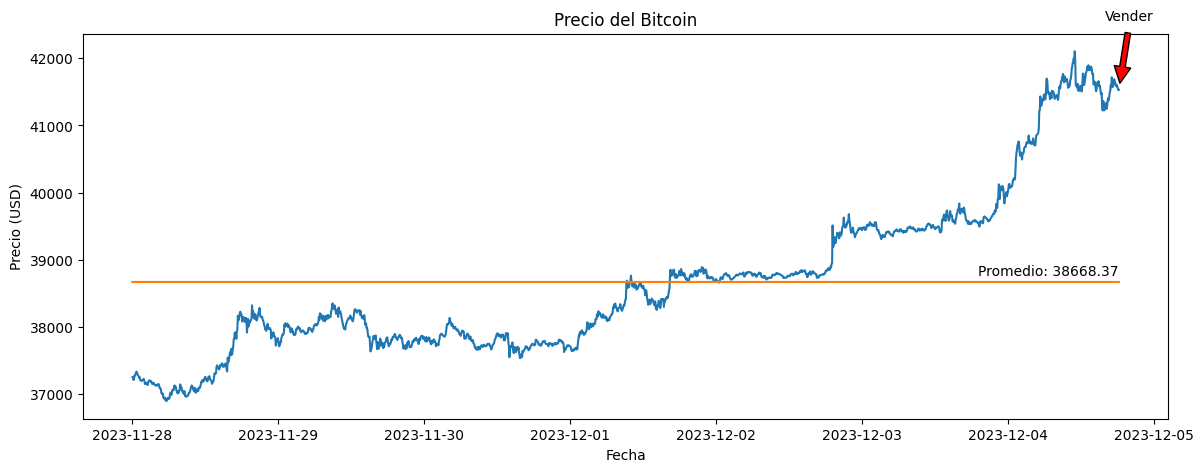

In [7]:
def visualizacion():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

  %matplotlib inline
  import matplotlib.patches as mpatches
  plt.rc('figure', figsize = (14,5))

  importar_base_bitcoin()

  df_bitcoin = df_bitcoin.assign(Mean = media_bitcoin)

  plt.plot(df_bitcoin.index, df_bitcoin['Close'])
  plt.plot(df_bitcoin.index, df_bitcoin['Mean'])

  plt.text(df_bitcoin.index[-1], media_bitcoin + 50, f'Promedio: {media_bitcoin:.2f}', color='black', verticalalignment='bottom', horizontalalignment='right')

  plt.title('Precio del Bitcoin')
  plt.xlabel('Fecha')
  plt.ylabel('Precio (USD)')

  if algoritmo_decision == 'Vender':
    plt.annotate('Vender', xy=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]), xytext=(-10, 50),
                  textcoords='offset points', arrowprops=dict(facecolor='red', shrink=0.1))
  elif algoritmo_decision == 'Comprar':
    plt.annotate('Comprar', xy=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]), xytext=(-10, 50),
                  textcoords='offset points', arrowprops=dict(facecolor='green', shrink=0.1))
  else:
    plt.annotate('Esperar', xy=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]), xytext=(-10, 50),
                 textcoords='offset points', arrowprops=dict(facecolor='black', shrink=0.1))
  plt.show()

visualizacion()

In [10]:
from IPython.display import clear_output

try:
  while(True):
    clear_output()
    importar_base_bitcoin()
    extraer_tendencia()
    limpieza_datos()
    tomar_decisiones()
    visualizacion()
    time.sleep(300)
except KeyboardInterrupt:
  clear_output()
  print('Proceso Finalizado')

Proceso Finalizado
